# Basic univariate forecasting

In [1]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from numpyro import distributions as dist

# Import dataset

We import a dataset from Prophet's original repository. We then put it into sktime-friendly format, where the index is a `pd.PeriodIndex` and the colums are the time series.

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df["ds"] = pd.to_datetime(df["ds"]).dt.to_period("D")
y = df.set_index("ds")
display(y)

,y
ds,
2007-12-10,9.590761
2007-12-11,8.519590
2007-12-12,8.183677
2007-12-13,8.072467
2007-12-14,7.893572
...,...
2016-01-16,7.817223
2016-01-17,9.273878
2016-01-18,10.333775


# Fit model

Here, we fit the univariate Prophet. The `exogenous_effects` parameter let us specify different relations between exogenous variables and the time series. If we do not specify `exogenous_effects`, all variables in X are assumed to be linearly related to the time series.

This argument is a list of tuples of the form `(effect_name, effect, regex_to_filter_relevant_columns)`, where `effect_name` is a string and `effect` is an instance of a subclass of `prophetverse.effects.BaseEffect`. The regex is used to filter the columns of X that are relevant for the effect, but can also be `None` (or its alias `prophetverse.utils.no_input_columns`) if no input in `X` is needed for the effect. For example, the seasonality effect already implemented in `prophetverse.effects` module does not need any input in `X`, so we can use `prophetverse.utils.no_input_columns` as the regex.

In [3]:
from prophetverse.sktime import Prophetverse
from prophetverse.sktime.seasonality import seasonal_transformer
from prophetverse.effects.linear import LinearEffect
from prophetverse.utils import no_input_columns
from prophetverse.effects.fourier import LinearFourierSeasonality


model = Prophetverse(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    exogenous_effects=[
        (
            "seasonality",
            LinearFourierSeasonality(
                freq="D",
                sp_list=[7, 365.25],
                fourier_terms_list=[3, 10],
                prior_scale=0.1,
                effect_mode="multiplicative",
            ),
            no_input_columns,
        ),
    ],
    noise_scale=0.05,
    optimizer_steps=20000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
)
model.fit(y=y)

100%|██████████| 20000/20000 [00:02<00:00, 8285.49it/s, init loss: 125081.3828, avg. loss [19001-20000]: -5126.2400]


Prophetverse(changepoint_interval=300, changepoint_prior_scale=0.0001,
             exogenous_effects=[('seasonality',
                                 LinearFourierSeasonality(effect_mode='multiplicative',
                                                          fourier_terms_list=[3,
                                                                              10],
                                                          freq='D',
                                                          prior_scale=0.1,
                                                          sp_list=[7, 365.25]),
                                 '^$')],
             optimizer_kwargs={'step_size': 0.0001}, optimizer_steps=20000)

## Forecasting

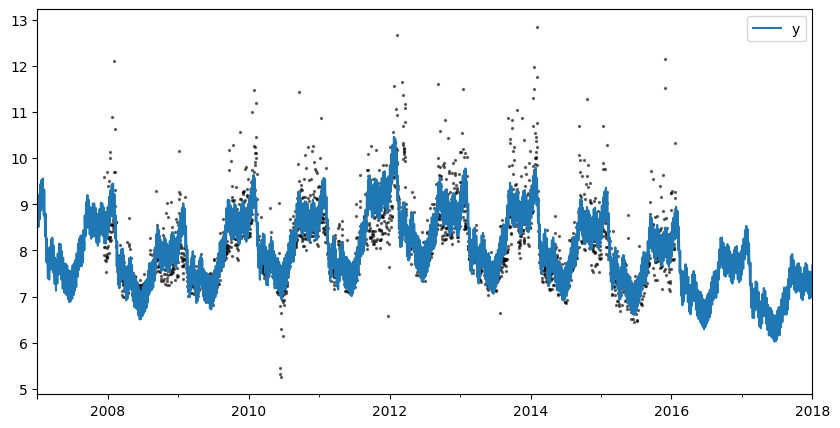

In [4]:
forecast_horizon = pd.period_range("2007-01-01", "2018-01-01", freq="D")
fig, ax = plt.subplots(figsize=(10, 5))
preds = model.predict(fh=forecast_horizon)
preds.plot.line(ax=ax)
ax.scatter(y.index, y, marker="o", color="k", s=2, alpha=0.5)

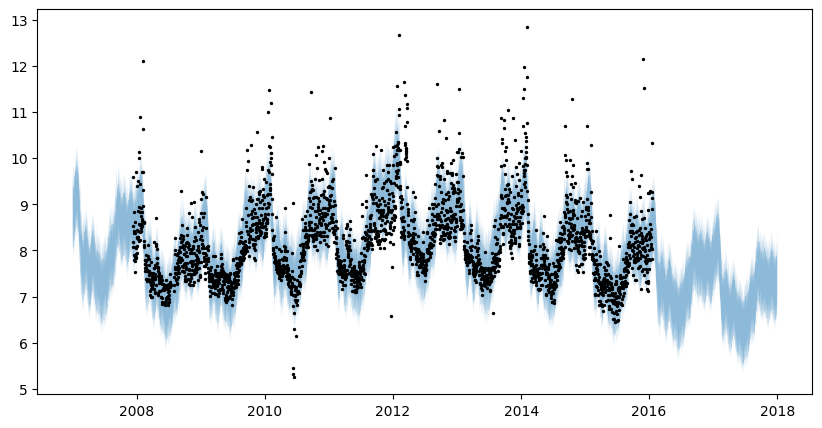

In [5]:
quantiles = model.predict_quantiles(fh=forecast_horizon, alpha=[0.1, 0.9])
fig, ax = plt.subplots(figsize=(10, 5))
# Plot area between quantiles
ax.fill_between(quantiles.index.to_timestamp(), quantiles.iloc[:, 0], quantiles.iloc[:, -1], alpha=0.5)
ax.scatter(y.index, y, marker="o", color="k", s=2, alpha=1)

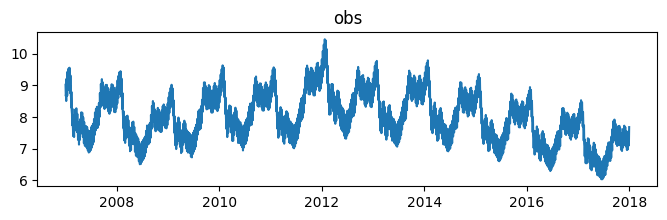

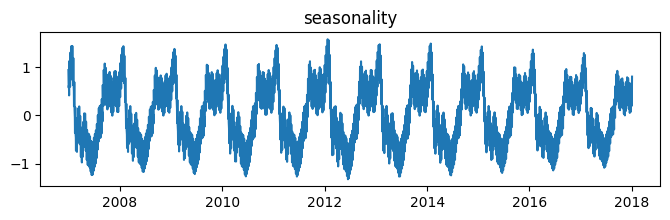

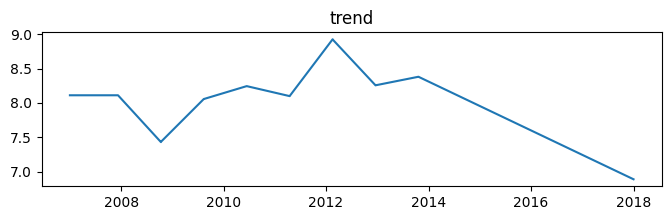

In [6]:
sites = model.predict_all_sites(fh=forecast_horizon)
for column in sites.columns:
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(sites.index.to_timestamp(), sites[column], label=column)
    ax.set_title(column)
    fig.show()

## Non-linear effects

Let's create a synthetic exogenous variable with a logarithmic impact on the series. To estimate this variable's effect, we will pass a custom `prophetverse.effects.LogEffect` to the `exogenous_effects` parameter.

<Axes: xlabel='ds'>

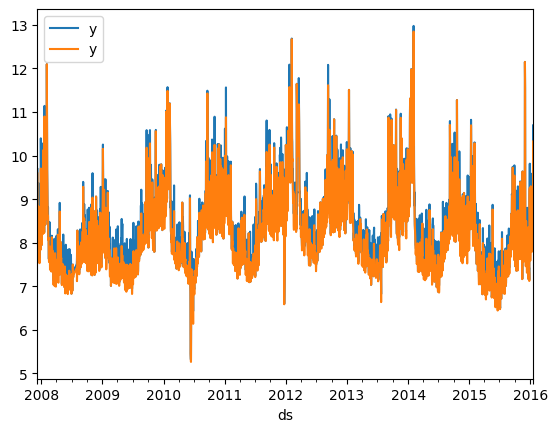

In [7]:
y2 = y.copy()
# Set numpy seed
np.random.seed(0)

# Create random input
X = pd.DataFrame(
    np.abs(np.random.rand(len(y2), 1))**4,
    index=y2.index,
    columns=["exog"],
)
true_exog_effect = np.log(1.5 * X["exog"].values.reshape((-1, 1)) + 1) * 0.8
y2 = y + true_exog_effect
ax = y2.plot.line()
y.plot.line(ax=ax)

In [8]:
from prophetverse.effects.log import LogEffect
from prophetverse.utils.regex import starts_with
import numpyro


exogenous_effects = [
    (
        "seasonality",
        LinearFourierSeasonality(
            freq="D",
            sp_list=[7, 365.25],
            fourier_terms_list=[3, 10],
            prior_scale=0.1,
            effect_mode="multiplicative",
        ),
        no_input_columns,
    ),
    (
        "exog",
        LogEffect(
            rate_prior=dist.Gamma(2, 1),
            scale_prior=dist.Gamma(2, 1),
            effect_mode="additive",
        ),
        starts_with("exog"),
    ),
]

model = Prophetverse(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    exogenous_effects=exogenous_effects,
    noise_scale=0.05,
    optimizer_steps=50000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
)
model.fit(y=y2, X=X)

100%|██████████| 50000/50000 [00:08<00:00, 5738.55it/s, init loss: 136774.5000, avg. loss [47501-50000]: -5131.3338]


Prophetverse(changepoint_interval=300, changepoint_prior_scale=0.0001,
             exogenous_effects=[('seasonality',
                                 LinearFourierSeasonality(effect_mode='multiplicative',
                                                          fourier_terms_list=[3,
                                                                              10],
                                                          freq='D',
                                                          prior_scale=0.1,
                                                          sp_list=[7, 365.25]),
                                 '^$'),
                                ('exog',
                                 LogEffect(effect_mode='additive',
                                           rate_prior=<numpyro.distributions.continuous.Gamma object at 0x3338408d0>,
                                           scale_prior=<numpyro.distributions.continuous.Gamma object at 0x333926b90>),
                                 '^(?:exog)')],
             optimizer_kwargs={'step_size': 0.0001}, optimizer_steps=50000)

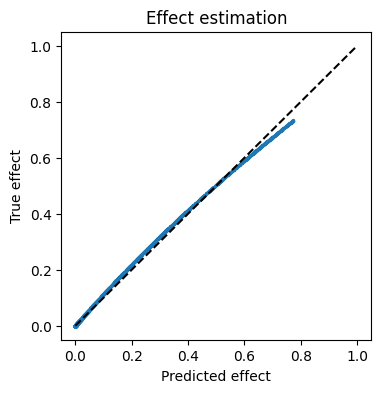

In [9]:
sites = model.predict_all_sites(fh=X.index, X=X)

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(sites["exog"],true_exog_effect, s=2)
# 45 degree line
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Predicted effect")
ax.set_ylabel("True effect")
ax.set_title("Effect estimation")
fig.show()


In [10]:
{k:v for k,v in model.inference_engine_.posterior_samples_.items() if k.startswith("exog")}

{'exog/log_scale': Array(0.11132193, dtype=float32),
 'exog/log_rate': Array(0.70778346, dtype=float32),
 'exog': Array([[0.00692783],
        [0.01891262],
        [0.00994325],
        ...,
        [0.02714626],
        [0.01312738],
        [0.05278062]], dtype=float32)}

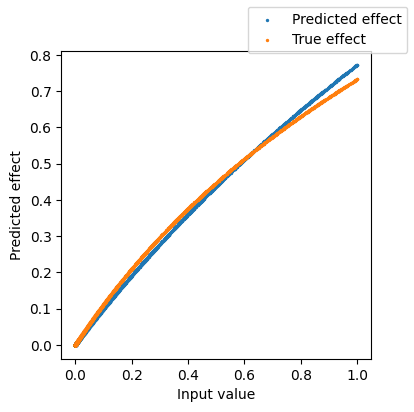

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(X["exog"], sites["exog"], s=2, label="Predicted effect")
ax.scatter(X["exog"], true_exog_effect, s=2, label="True effect")
ax.set_xlabel("Input value")
ax.set_ylabel("Predicted effect")
fig.legend()
fig.show()